In [1]:
import pandas as pd
from pandas import merge
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

%matplotlib inline
sns.set(style="whitegrid")

In [2]:
# Loading the datasets and combining
df_oct = pd.read_csv("data/2019-Oct.csv")
df_nov = pd.read_csv("data/2019-Nov.csv")

df = pd.concat([df_oct, df_nov], ignore_index=True)

In [76]:
df.shape
df.head()
df.info()
df.isnull().sum()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
Index: 109950731 entries, 0 to 109950742
Data columns (total 8 columns):
 #   Column        Dtype              
---  ------        -----              
 0   event_time    datetime64[ns, UTC]
 1   event_type    object             
 2   product_id    int64              
 3   category_id   int64              
 4   price         float64            
 5   user_id       int64              
 6   user_session  object             
 7   event_hour    int32              
dtypes: datetime64[ns, UTC](1), float64(1), int32(1), int64(3), object(2)
memory usage: 7.0+ GB


Index(['event_time', 'event_type', 'product_id', 'category_id', 'price',
       'user_id', 'user_session', 'event_hour'],
      dtype='object')

In [5]:
#Converting event_time column to datetime format and sorting the dates
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values('event_time')

In [6]:
#Checking nulls
df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    35413780
brand            15341158
price                   0
user_id                 0
user_session           12
dtype: int64

In [7]:
# We dont need the category_code and brand columns for this analysis
df.drop(columns=['category_code', 'brand'], inplace=True)
df = df[df['user_session'].notnull()]
df.isnull().sum()

event_time      0
event_type      0
product_id      0
category_id     0
price           0
user_id         0
user_session    0
dtype: int64

In [8]:
df.head()
df.shape

(109950731, 7)

In [9]:
# Distribution of each event type
df['event_type'].value_counts()
df['event_type'].value_counts(normalize=True) * 100

event_type
view        94.892965
cart         3.597460
purchase     1.509574
Name: proportion, dtype: float64

In [10]:
df['price'].describe()

count    1.099507e+08
mean     2.916348e+02
std      3.566800e+02
min      0.000000e+00
25%      6.796000e+01
50%      1.649300e+02
75%      3.601100e+02
max      2.574070e+03
Name: price, dtype: float64

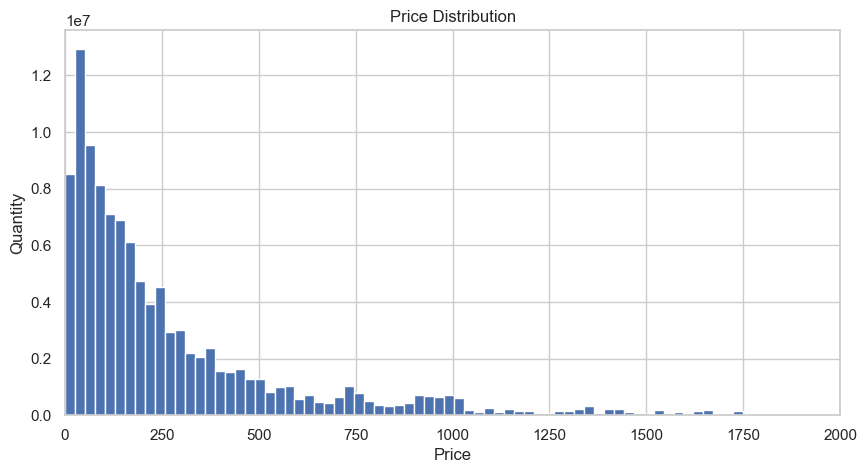

In [11]:
# Distribution of Price
plt.figure(figsize = (10,5))
df['price'].hist(bins=100)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Quantity")
plt.xlim(0,2000)
plt.grid(True)
plt.show()

In [12]:
# Double check the timeline included in the combined dataset
df['event_time'].min(), df['event_time'].max()

(Timestamp('2019-10-01 00:00:00+0000', tz='UTC'),
 Timestamp('2019-11-30 23:59:59+0000', tz='UTC'))

In [13]:
# Number of users
df['user_id'].nunique(), df['user_session'].nunique()

(5316649, 23016650)

In [14]:
# Filter purchase events and calculate total amount spent by each user
purchase_df = df[df['event_type'] == 'purchase']
user_spent = purchase_df.groupby('user_id')['price'].sum().reset_index(name='total_spent')

In [15]:
# Filter cart events and calculate how many times each user added products to cart
cart_df = df[df['event_type'] == 'cart']
user_cart_count = cart_df.groupby('user_id').size().reset_index(name = 'cart_count')

In [16]:
# Calculate number of purchases per user
user_purchase_count = purchase_df.groupby('user_id').size().reset_index(name='purchase_count')

In [17]:
# Calculate average purchase price per user
user_avg_price = purchase_df.groupby('user_id')['price'].mean().reset_index()
user_avg_price.columns = ['user_id', 'avg_purchase_price']

In [18]:
# Combine all the user features into a single dataframe

user_features = [user_spent, user_cart_count, user_purchase_count, user_avg_price]

user_df = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='outer'), user_features)

user_df.fillna(0, inplace=True)

user_df.head(10)

,user_id,total_spent,cart_count,purchase_count,avg_purchase_price
0,74383042,0.0,1.0,0.0,0.0
1,94566147,0.0,1.0,0.0,0.0
2,107837897,0.0,4.0,0.0,0.0
3,121339215,0.0,1.0,0.0,0.0
4,124298297,0.0,2.0,0.0,0.0
5,125917727,0.0,4.0,0.0,0.0
6,126150271,0.0,1.0,0.0,0.0
7,128968633,0.0,2.0,0.0,0.0
8,138340325,93.5,0.0,1.0,93.5
9,143562268,0.0,1.0,0.0,0.0


In [19]:
print("Row count sum:", len(df))
print("Unique user count:", df['user_id'].nunique())
print("user count of user_df:", user_df['user_id'].nunique())

Row count sum: 109950731
Unique user count: 5316649
user count of user_df: 1185685


In [21]:
# Different users according to their online behavior
only_view = user_df[(user_df['cart_count'] == 0) & (user_df['purchase_count'] == 0)]

abandoned_cart = user_df[(user_df['cart_count'] > 0) & (user_df['purchase_count'] == 0)]

purchasers = user_df[(user_df['purchase_count'] > 0)]


In [22]:
# Segment users and calculate purchase-related metrics
user_df['conversion_rate'] = user_df['purchase_count'] / user_df['cart_count'].replace(0, np.nan)
user_df['conversion_rate'] = user_df['conversion_rate'].fillna(0)

user_df['avg_cart_value'] = np.where(user_df['cart_count'] == 0, 0, user_df['total_spent'] / user_df['cart_count'])

user_df['purchase_flag'] = (user_df['purchase_count'] > 0).astype(int)

In [23]:
print(user_df['purchase_flag'].value_counts())

purchase_flag
1    697470
0    488215
Name: count, dtype: int64


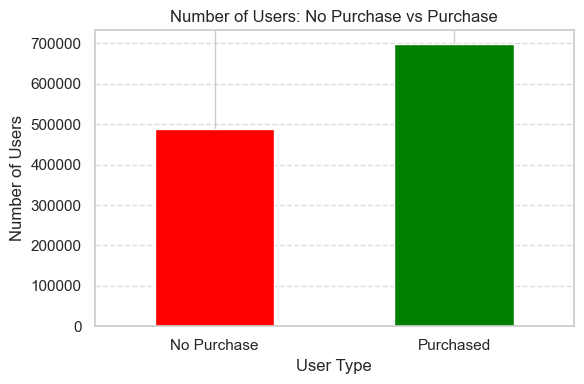

In [24]:
# Visualising purchase count
purchase_counts = user_df['purchase_flag'].value_counts().sort_index()

plt.figure(figsize=(6,4))
purchase_counts.plot(kind='bar', color=['red', 'green'])
plt.xticks([0, 1], ['No Purchase', 'Purchased'], rotation=0)
plt.title('Number of Users: No Purchase vs Purchase')
plt.xlabel('User Type')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
# Filter out invalid or extreme conversion rates and visualise the distribution of valid conversion rates (≤ 5)
valid_cr = user_df['conversion_rate']
valid_cr = valid_cr[np.isfinite(valid_cr)]
valid_cr = valid_cr.dropna()

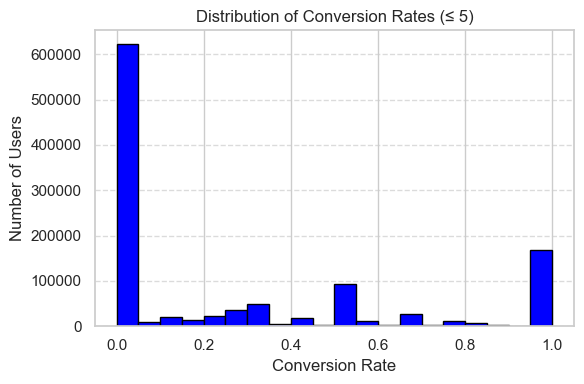

In [26]:
# Plots the distribution of user conversion rates that are less than or equal to 1.
filtered_cr = valid_cr[valid_cr <= 1]

plt.figure(figsize=(6, 4))
filtered_cr.hist(bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Conversion Rates (≤ 5)')
plt.xlabel('Conversion Rate')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

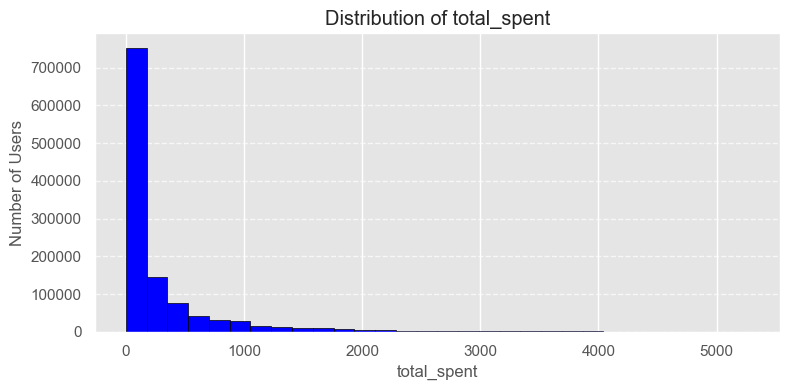

In [75]:
# Remove top 1% spenders as outliers and create the distribution of total spending for the remaining users
threshold = user_df['total_spent'].quantile(0.99)
filtered_spent = user_df[user_df['total_spent'] <= threshold]

plt.figure(figsize=(8, 4))
plt.hist(filtered_spent['total_spent'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of total_spent')
plt.xlabel('total_spent')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

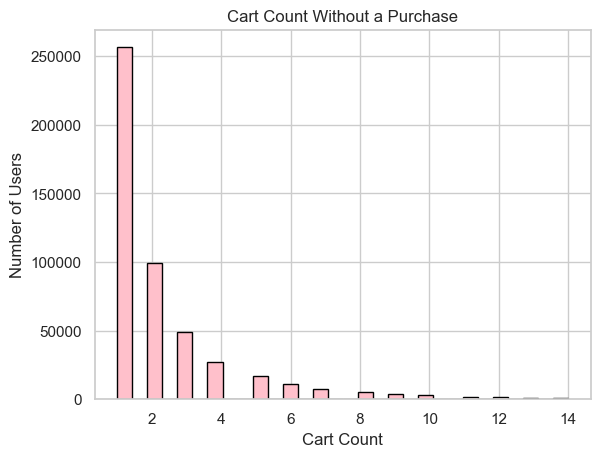

In [30]:
# Remove top 1% spenders as outliers and create the distribution of cart count without a purchase for the remaining users

threshold = abandoned_cart['cart_count'].quantile(0.99)
filtered_cart_count = abandoned_cart[abandoned_cart['cart_count'] <= threshold]

plt.hist(filtered_cart_count['cart_count'], bins=30, color='pink', edgecolor='black')
plt.title('Cart Count Without a Purchase')
plt.xlabel('Cart Count')
plt.ylabel('Number of Users')
plt.show()

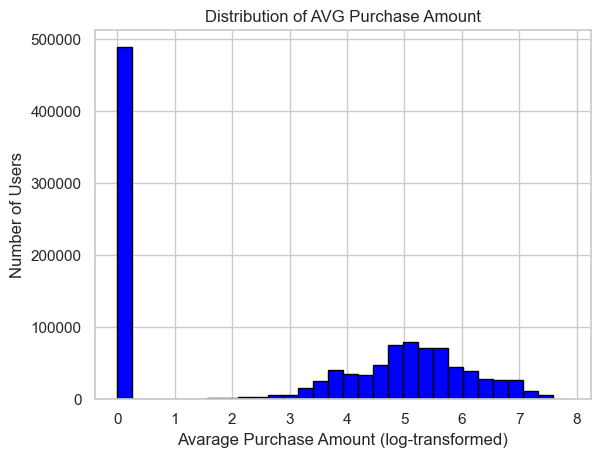

In [31]:
# Applied log transformation to average purchase price for better visualisation and plot its distribution
user_df['log_avg_purchase_price'] = np.log1p(user_df['avg_purchase_price'])

plt.hist(user_df['log_avg_purchase_price'], bins=30, color='blue', edgecolor='black')
plt.title("Distribution of AVG Purchase Amount")
plt.xlabel("Average Purchase Amount (log-transformed)")
plt.ylabel("Number of Users")
plt.show()

In [33]:
# Scaling for k-means segmentation
features_to_scale = ['total_spent', 'conversion_rate', 'avg_cart_value', 'avg_purchase_price']

clean_df = user_df[features_to_scale].replace([np.inf, -np.inf], np.nan).dropna()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(clean_df)
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale)

scaled_df.head()

,total_spent,conversion_rate,avg_cart_value,avg_purchase_price
0,-0.23961,-0.580888,-0.376324,-0.602425
1,-0.23961,-0.580888,-0.376324,-0.602425
2,-0.23961,-0.580888,-0.376324,-0.602425
3,-0.23961,-0.580888,-0.376324,-0.602425
4,-0.23961,-0.580888,-0.376324,-0.602425


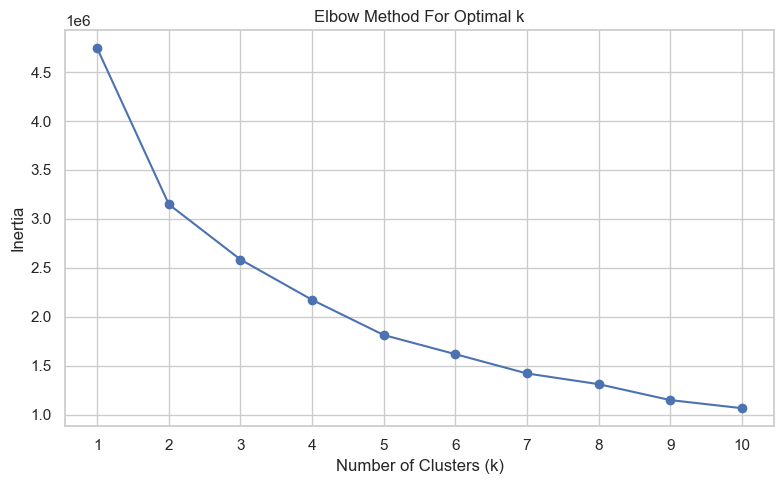

In [34]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)  

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Apply KMeans clustering with 4 clusters based on the optimal k from Elbow Method

kmeans = KMeans(n_clusters=4, random_state=42)

kmeans.fit(scaled_df)

scaled_df['cluster'] = kmeans.labels_

In [ ]:
# Silhouette score to evaluate cluster separation quality

sample_scaled = scaled_df.drop(columns=['cluster']).sample(n=100000, random_state=42)
sample_labels = scaled_df.loc[sample_scaled.index, 'cluster']

score = silhouette_score(sample_scaled, sample_labels)
print(f"Sampled Silhouette Score (100,000 users): {score:.4f}")

In [36]:
# Merge cluster labels back to the original user data
user_df_clusters = user_df.loc[scaled_df.index].copy()
user_df_clusters['clusters'] = kmeans.labels_

In [37]:
# Calculate the average values of each feature for each cluster to build customer profiles
cluster_profile = user_df_clusters.groupby('clusters').mean(numeric_only=True)
pd.set_option('display.float_format', '{:,.2f}'.format)
cluster_profile

,user_id,total_spent,cart_count,purchase_count,avg_purchase_price,conversion_rate,avg_cart_value,purchase_flag,log_avg_purchase_price
clusters,,,,,,,,,
0,"541,059,985.87",91.60,3.11,0.63,59.51,0.08,10.15,0.40,1.87
1,"539,859,664.30","2,176.21",4.54,2.90,920.55,0.72,607.03,1.00,6.77
2,"541,937,397.28",587.72,3.35,2.78,218.14,1.03,197.13,1.00,5.13
3,"535,807,124.37","11,606.02",14.54,17.91,811.65,3.33,"2,067.76",1.00,6.51


In [42]:
user_df_clusters['clusters'].value_counts()

clusters
0    816096
2    277213
1     85330
3      7046
Name: count, dtype: int64

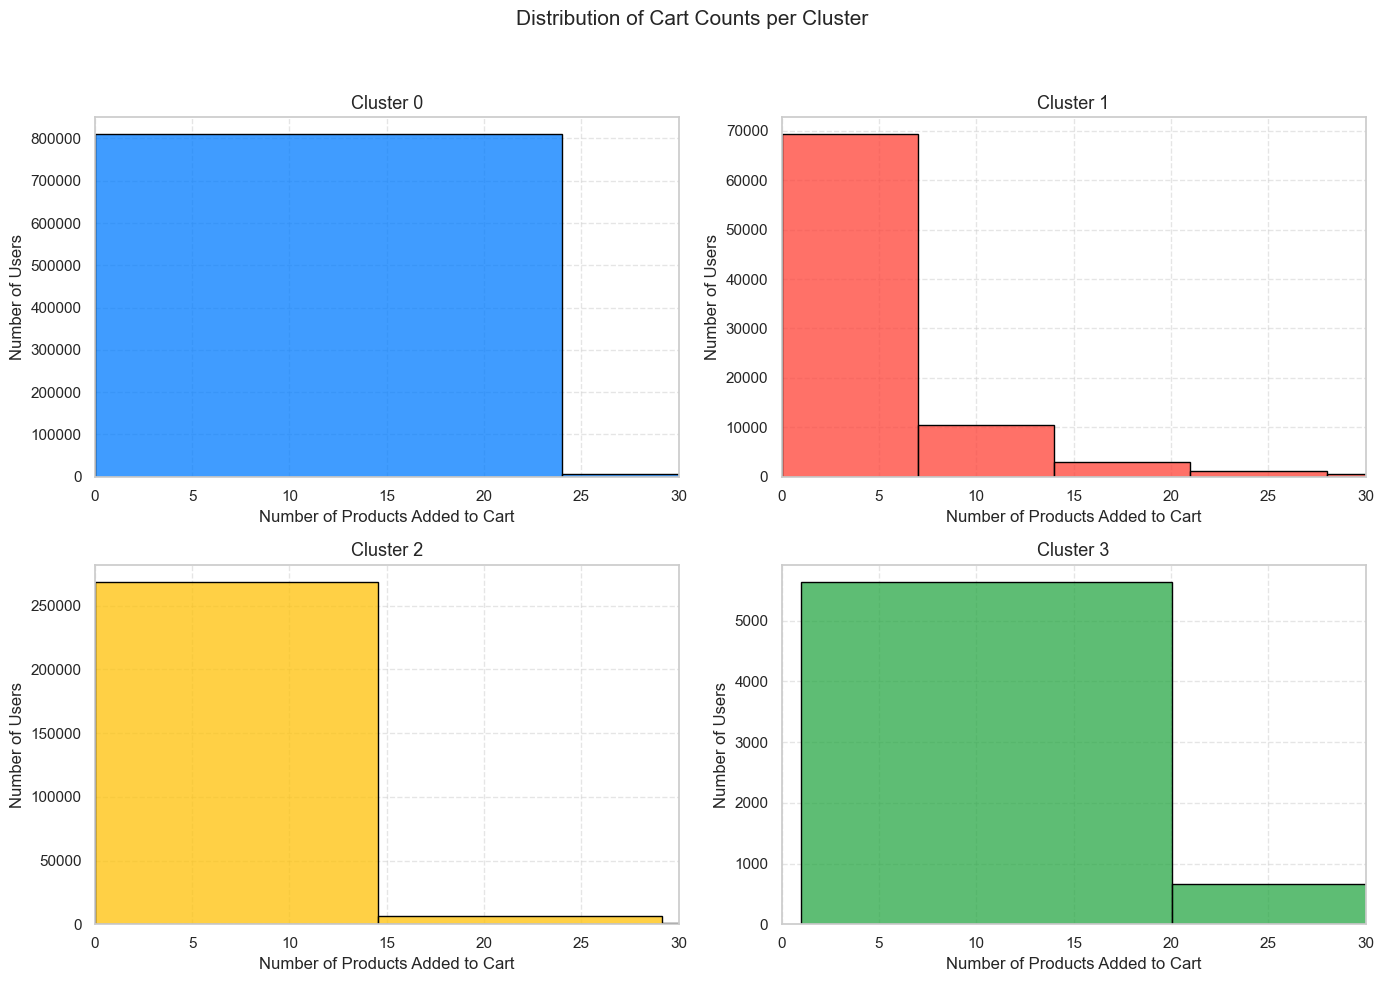

In [53]:
# Visualising cart counts by clusters
colours = ['#007BFF', '#FF4136', '#FFC107', '#28A745']
clusters = sorted(user_df_clusters['clusters'].unique())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    cluster_data = user_df_clusters[user_df_clusters['clusters'] == cluster]

    if cluster_data.empty:
        continue

    sns.histplot(
        data=cluster_data,
        x='cart_count',
        bins=30,
        kde=False,
        color=colours[i],
        edgecolor='black',
        stat='count',
        ax=axes[i]
    )

    axes[i].set_title(f'Cluster {cluster}', fontsize=13)
    axes[i].set_xlim(0, 30)
    axes[i].set_xlabel('Number of Products Added to Cart')
    axes[i].set_ylabel('Number of Users')
    axes[i].grid(True, linestyle='--', alpha=0.5)

for j in range(len(clusters), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribution of Cart Counts per Cluster', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

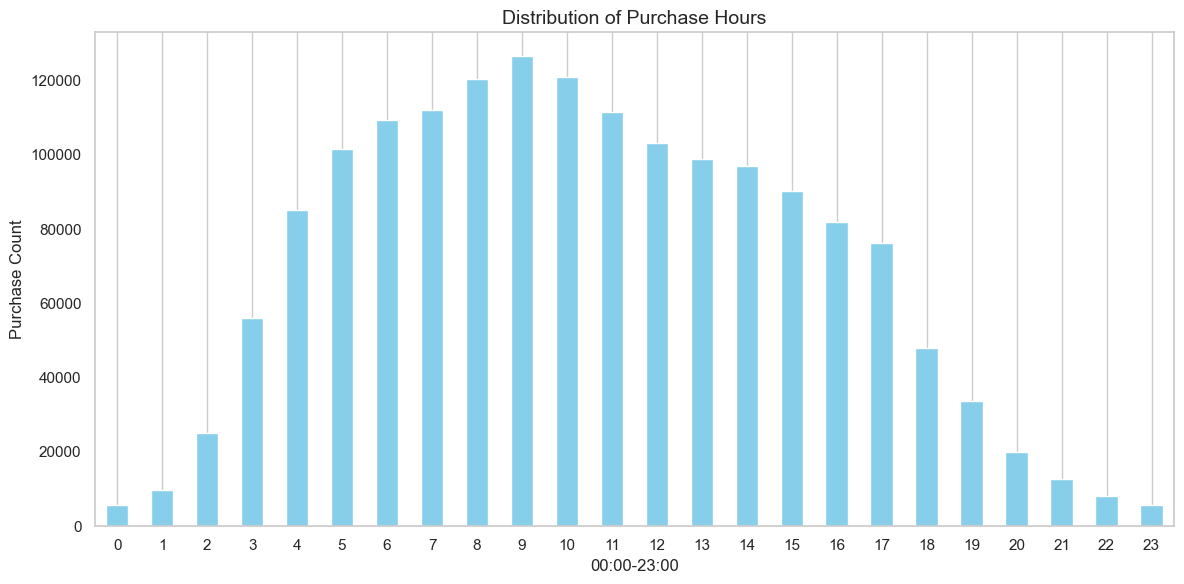

In [48]:
# Visualising the distribution of purchase hours
df['event_hour'] = df['event_time'].dt.hour

purchase_df = df[df['event_type'] == 'purchase']

hourly_purchase_counts = purchase_df['event_hour'].value_counts().sort_index()


plt.figure(figsize=(12, 6))
hourly_purchase_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Purchase Hours', fontsize=14)
plt.xlabel('00:00-23:00')
plt.ylabel('Purchase Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [49]:
# Calculate the number of unique sessions per user
session_counts = df.groupby('user_id')['user_session'].nunique()
# Merge session count data back into the main user DataFrame
user_df_clusters = user_df_clusters.merge(session_counts, on='user_id', how='left')
# Rename the merged column for clarity
user_df_clusters.rename(columns={'user_session_y': 'user_session'}, inplace=True)

In [54]:
# Define a function to summarise key metrics for each segment

def summarize_segment(df, segment_name):
    return {
        'Segment': segment_name,
        'User Count': len(df),
        'Avg Cart Count': round(df['cart_count'].mean(), 2),
        'Avg Purchase Count': round(df['purchase_count'].mean(), 2),
        'Avg Total Spent': round(df['total_spent'].mean(), 2),
        'Avg Session Count': round(df['user_session'].mean(), 2)
    }

abandoned_cart = user_df_clusters[(user_df_clusters['purchase_count'] == 0) & (user_df_clusters['cart_count'] > 0)]
single_purchase = user_df_clusters[user_df_clusters['purchase_count'] == 1]
repeat_purchases = user_df_clusters[user_df_clusters['purchase_count'] > 1]

segments_summary = [
    summarize_segment(abandoned_cart, 'Cart Leavers'),
    summarize_segment(single_purchase, 'Single Purchasers'),
    summarize_segment(repeat_purchases, 'Loyal Users')
]

segment_df = pd.DataFrame(segments_summary)
display(segment_df)

,Segment,User Count,Avg Cart Count,Avg Purchase Count,Avg Total Spent,Avg Session Count
0,Cart Leavers,488215,2.44,0.00,0.00,8.37
1,Single Purchasers,402145,2.21,1.00,267.46,7.94
2,Loyal Users,295325,6.35,4.26,"1,346.30",14.46


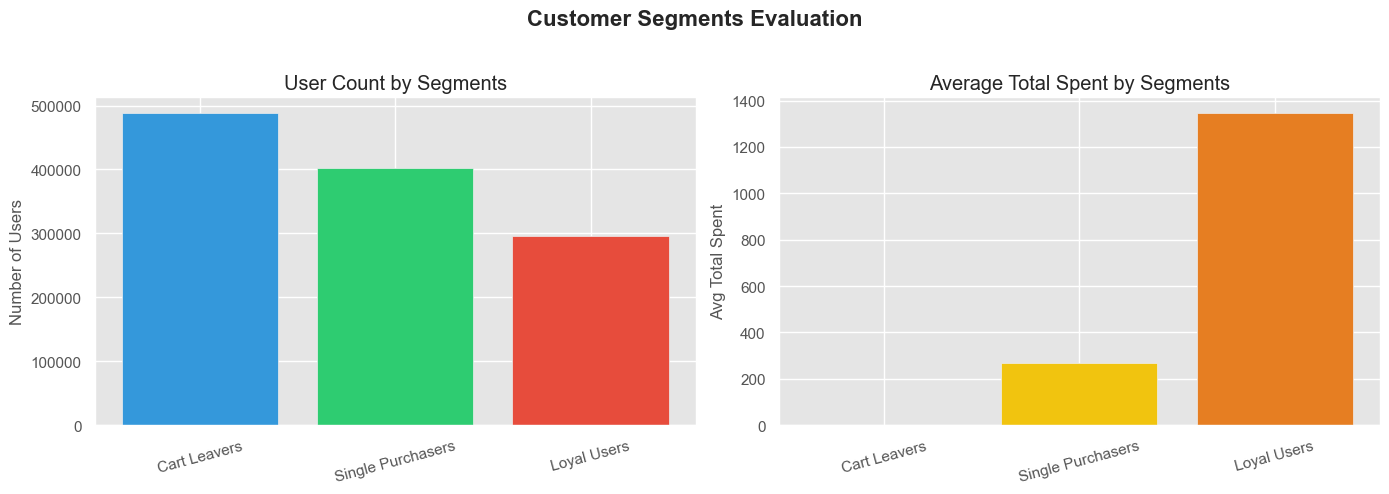

In [55]:
# Creating side by side bar charts to compare user count and average spending across customer segments.
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

colors1 = ['#3498db', '#2ecc71', '#e74c3c']
colors2 = ['#9b59b6', '#f1c40f', '#e67e22']

axs[0].bar(segment_df['Segment'], segment_df['User Count'], color=colors1)
axs[0].set_title('User Count by Segments')
axs[0].set_ylabel('Number of Users')
axs[0].tick_params(axis='x', rotation=15)

axs[1].bar(segment_df['Segment'], segment_df['Avg Total Spent'], color=colors2)
axs[1].set_title('Average Total Spent by Segments')
axs[1].set_ylabel('Avg Total Spent')
axs[1].tick_params(axis='x', rotation=15)

plt.suptitle('Customer Segments Evaluation', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

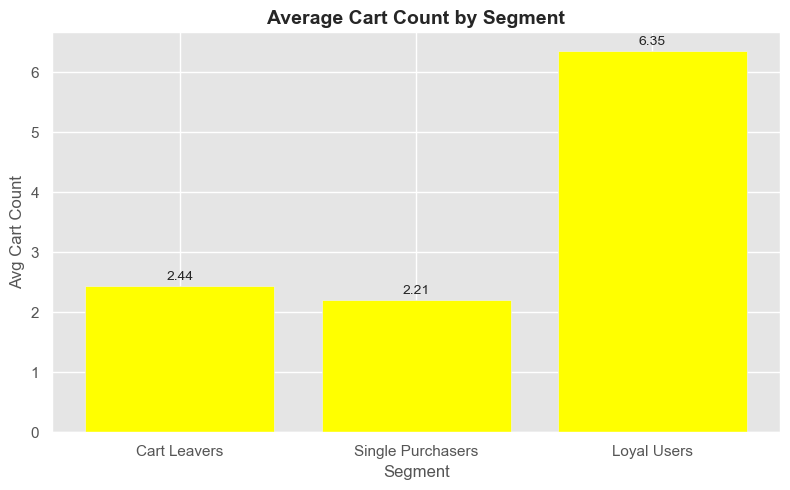

In [56]:
# Displays the average number of items added to cart for each segment using a bar chart with value labels.
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(segment_df['Segment'], segment_df['Avg Cart Count'], color='yellow')

ax.set_title('Average Cart Count by Segment', fontsize=14, fontweight='bold')
ax.set_xlabel('Segment', fontsize=12)
ax.set_ylabel('Avg Cart Count', fontsize=12)

for i, v in enumerate(segment_df['Avg Cart Count']):
    ax.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [57]:
# Calculates the number of unique sessions per user and merges this information into the main user dataset.
session_count_df = df.groupby('user_id')['user_session'].nunique().reset_index()
session_count_df.columns = ['user_id', 'session_count']

user_df = user_df.merge(session_count_df, on='user_id', how='left')

In [60]:
#Calculating the correlation value between session and purchase count
correlation = user_df['session_count'].corr(user_df['purchase_count'])
print(f"Correlation (Session vs Purchase): {correlation:.2f}")

Correlation (Session vs Purchase): 0.14


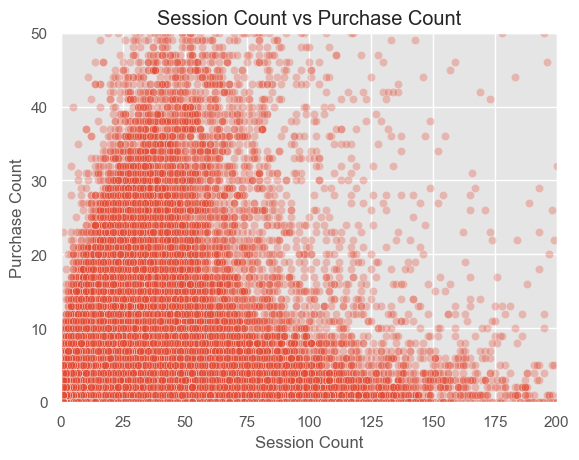

In [61]:
# Plots a scatter graph to explore the relationship between session count and purchase count per user.
sns.scatterplot(data=user_df, x='session_count', y='purchase_count', alpha=0.3)
plt.title('Session Count vs Purchase Count')
plt.xlabel('Session Count')
plt.ylabel('Purchase Count')

plt.xlim(0, 200)
plt.ylim(0, 50)
plt.show()

In [62]:
# Calculates and prints the proportion of users who did not complete a purchase.
cart_abandonment_rate = (user_df['purchase_count'] == 0).sum() / len(user_df)
print(f"Cart Abandonment Rate: {cart_abandonment_rate:.2%}")

Cart Abandonment Rate: 41.18%


In [63]:
# Calculates the percentage of users who made more than one purchase.
repeat_rate = (user_df['purchase_count'] > 1).mean()
print(f"Repeat Purchase Rate: {repeat_rate:.2%}")

Repeat Purchase Rate: 24.91%


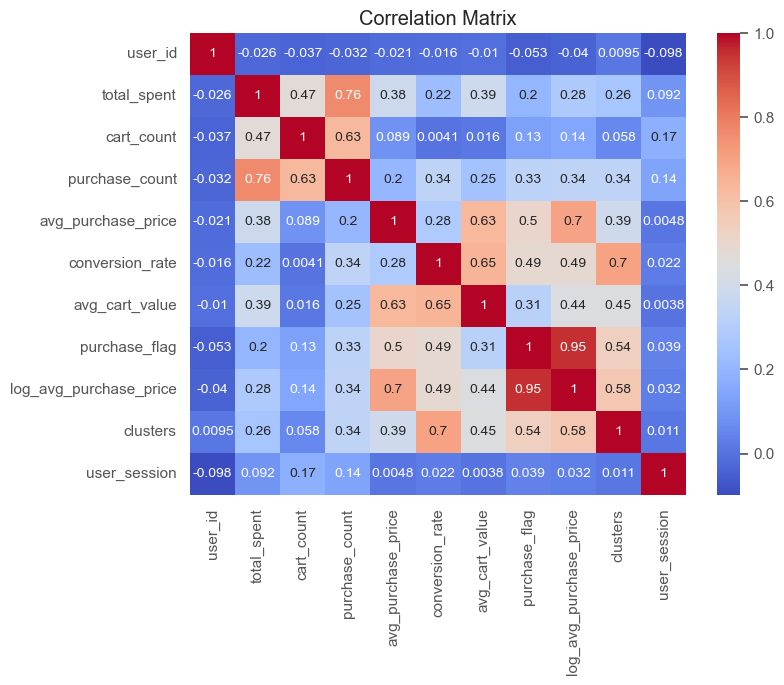

In [64]:
# Visualises the correlation between numerical features in the clustered user dataset using a heatmap.
plt.figure(figsize=(8,6))
sns.heatmap(user_df_clusters.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [65]:
# Assigns segment labels based on user behaviour and merges them into the main user dataset.
user_df_clusters.loc[abandoned_cart.index, 'Segment'] = 'Cart Leavers'
user_df_clusters.loc[single_purchase.index, 'Segment'] = 'Single Purchasers'
user_df_clusters.loc[repeat_purchases.index, 'Segment'] = 'Loyal Users'

user_df = user_df.merge(user_df_clusters[['user_id', 'Segment']], on='user_id', how='left')

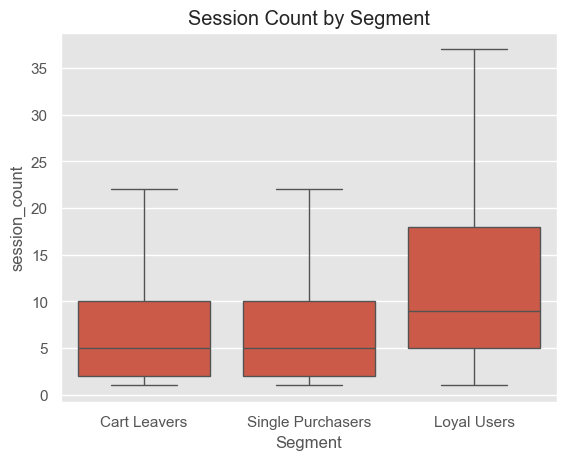

In [66]:
# Displays the distribution of session counts for each segment using a boxplot.
sns.boxplot(data=user_df, x='Segment', y='session_count', showfliers=False)
plt.title('Session Count by Segment')
plt.show()

In [67]:
# Calculates the average time gap in hours between consecutive purchases for each user.
purchase_df = df[df['event_type'] == 'purchase'].copy()

purchase_df['event_time'] = pd.to_datetime(purchase_df['event_time'])
purchase_df.sort_values(by=['user_id', 'event_time'], inplace=True)

purchase_df['prev_purchase_time'] = purchase_df.groupby('user_id')['event_time'].shift(1)

purchase_df['time_diff_hours'] = (purchase_df['event_time'] - purchase_df['prev_purchase_time']).dt.total_seconds() / 3600

avg_purchase_gap = purchase_df.groupby('user_id')['time_diff_hours'].mean().reset_index()
avg_purchase_gap.rename(columns={'time_diff_hours': 'avg_purchase_gap_hours'}, inplace=True)

avg_purchase_gap.head()

,user_id,avg_purchase_gap_hours
0,138340325,NaN
1,225644257,NaN
2,253299396,NaN
3,256164170,NaN
4,264649825,5.12


In [72]:
# Computes and prints the overall average purchase frequency among repeat buyers.
filtered_gap_df = avg_purchase_gap.dropna()

overall_avg_gap = filtered_gap_df['avg_purchase_gap_hours'].mean()

print(f"Avg time frequency of users who made a purchase more than once: {overall_avg_gap:.2f} hour")

Avg time frequency of users who made a purchase more than once: 150.77 hour


In [70]:
filtered_gap_df['avg_purchase_gap_hours'].describe()

count   295,325.00
mean        150.77
std         223.74
min           0.00
25%           1.73
50%          56.77
75%         203.28
max       1,450.81
Name: avg_purchase_gap_hours, dtype: float64

In [74]:
# Removes outliers using the IQR method and recalculates the average purchase frequency among repeat buyers.
Q1 = filtered_gap_df['avg_purchase_gap_hours'].quantile(0.25)
Q3 = filtered_gap_df['avg_purchase_gap_hours'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

no_outliers_df = filtered_gap_df[
    (filtered_gap_df['avg_purchase_gap_hours'] >= lower_bound) &
    (filtered_gap_df['avg_purchase_gap_hours'] <= upper_bound)
]

new_avg_gap = no_outliers_df['avg_purchase_gap_hours'].mean()

print(f"Avg time frequency of users who made a purchase more than once (without outliers): {new_avg_gap:.2f} hour")

Avg time frequency of users who made a purchase more than once (without outliers): 98.09 hour
